# CNN Image Classification-CIFAR-10

Building and evaluating CNN model for image classification using the CIFAR-10 dataset. The implementation followed an **object-oriented programming (OOP) approach**, encapsulating dataset processing, model construction, and evaluation into modular components. I conducted `4` experiments by changing the model architecture and hyperparameters, the best model was from the `4th` experiment, where achieved `80%` test accuracy with a loss of `0.50`, outperforming others in precision `85%` and recall `77%`.

<br>

**Key Features**:

- ELU Activation: Enhanced gradient flow in deeper layers.

- Selective Dropout: Prevented overfitting without sacrificing feature extraction.

- Batch Normalization: Stabilized training across all layers.

<br>

|       **Model**       | **Accuracy** | **Loss** | **Precision** | **Recall** |                  **Key Modifications**                  |
|:---------------------:|:----------------:|:--------:|:------------:|:----------:|:------------------------------------------------:|
| **Baseline**  |        73%       |   0.80   |    79%     |    69%    | 2 Conv layers, ReLU, no dropout or batch norm  |
| **Experiment 2**      |        71%       |   0.84   |     79%     |    63%    | Added dropout (0.1, 0.2), BN=2, data augmentation |
| **Experiment 3**      |        77%       |   0.68   |     83%     |    72%    | 3 Conv layers, no dropout, GELU activation, BN=3            |
| **Experiment 4**      |      **81%**      | **0.50** |   **85%**   |  **77%**  | 3 Conv layers, ELU activation, BN=3, selective dropout (0, 0, 0.2) |


<br>

**Challenges Encountered**:

- Overfitting

- Dropout Tuning

- Activation Selection

- Training Time



## Import Dependencies

In [1]:
from warnings import filterwarnings; filterwarnings("ignore")
from dataclasses import dataclass, field
from keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Construct the Dataset Skeleton and Its Utilities

In [ ]:
class Dataset:
  """
  Handles dataset loading, preprocessing, visualization and generation.
  """
  def __init__(self, name, normalized=False, encoded=False):
    """
    Initializes the dataset with metadata and processing flags.
    """
    self.name        = name
    self.normalized  = normalized
    self.encoded     = encoded
    self.classes     = ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
    self.num_classes = len(self.classes)


  def normalize(self, train_input, test_input):
    """
    Normalizes the dataset inputs to the range [0,1].
    """
    train_input     = train_input / 255
    test_input      = test_input  / 255
    self.normalized = True

    return train_input, test_input


  def encode(self, train_labels, test_labels):
    """
    Converts class labels into one-hot encoded format.
    """
    train_labels = to_categorical(train_labels, num_classes=self.num_classes)
    test_labels  = to_categorical(test_labels,  num_classes=self.num_classes)
    self.encoded = True

    return train_labels, test_labels


  def load(self, display=True):
    """
    Loads and preprocesses the dataset, normalizing and encoding if specified.

    Displays dataset information if `display` is True.
    """
    (train_input, train_labels), (test_input, test_labels) = load_data()

    train_labels = train_labels.flatten()
    test_labels  = test_labels. flatten()

    if self.normalized: train_input, test_input = self.normalize(train_input, test_input)
    if self.encoded:  train_labels, test_labels = self.encode(train_labels,  test_labels)

    if display:
      information = pd.Series({"Name"        : self.name,
                               "Normalized"  : self.normalized,
                               "Encoded"     : self.encoded,
                               "Train Inputs": train_input.shape,
                               "Test Inputs" : test_input.shape,
                               "Train Labels": train_labels.shape,
                               "Test Labels" : test_labels.shape,
                               "Classes"     : self.num_classes})

      print("-"*35, information.to_string(), "-"*35, sep="\n")

    return train_input, test_input, train_labels, test_labels


  def visualize(self, inputs, target):
    """
    Visualizes a sample of the dataset images with their corresponding labels.
    """
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(inputs[i])
        plt.title(self.classes [np.argmax(target[i])])
        plt.xlabel(self.classes[np.argmax(target[i])])
        plt.axis("off")

    plt.show()


  @staticmethod
  def generate(train_input):
    """
    Generate images with random transformations for data augmentation.
    """
    generator   = ImageDataGenerator(rotation_range    =10,
                                     width_shift_range =0.1,
                                     height_shift_range=0.1,
                                     zoom_range        =0.1)

    generator.fit(train_input)

    return generator

### Load the dataset and display its information

In [ ]:
dataset = Dataset(name="CIFAR-10",  normalized=True,  encoded=True)

train_input, test_input, train_labels, test_labels = dataset.load()

-----------------------------------
Name                      CIFAR-10
Normalized                    True
Encoded                       True
Train Inputs    (50000, 32, 32, 3)
Test Inputs     (10000, 32, 32, 3)
Train Labels           (50000, 10)
Test Labels            (10000, 10)
Classes                         10
-----------------------------------


### Display a few samples of the dataset

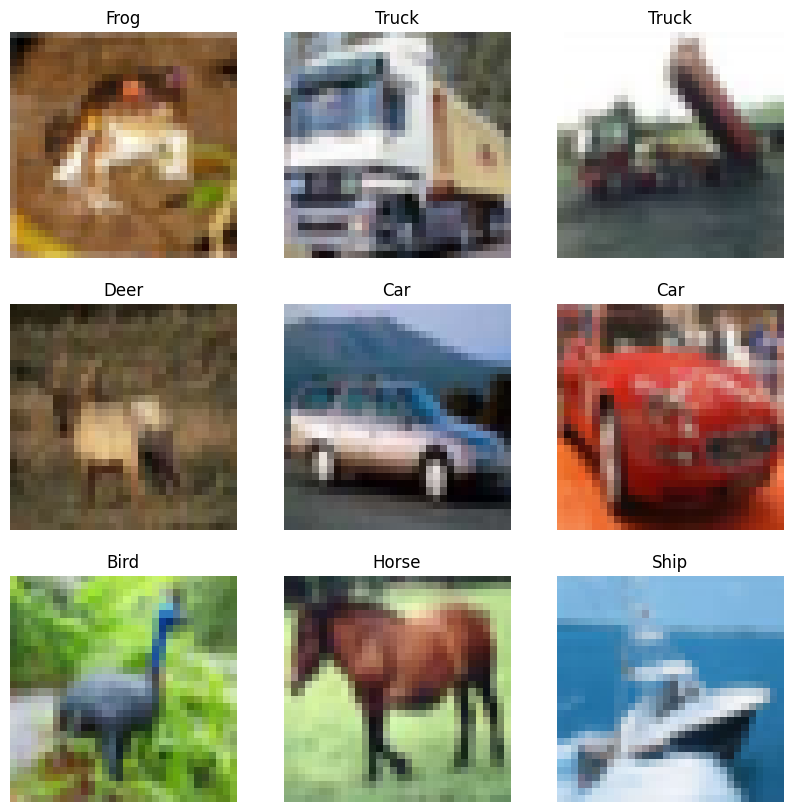

In [ ]:
dataset.visualize(inputs=train_input, target=train_labels)

## Setup Model Configurations and Hyperparameters

### Define the `learning rate scheduler` and `early stopping` callbacks

In [ ]:
def schedule(epoch):
    """
    Adjust the learning rate based on the epoch number using exponential decay.
    """
    lr           = 0.001
    decay_factor = 0.1
    decay_epochs = 5

    return lr * (decay_factor ** (epoch // decay_epochs))


early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler   = LearningRateScheduler(schedule=schedule,  verbose=1)

### Construct the model configurations skeleton

In [ ]:
@dataclass()
class Config:
    """
    Stores hyperparameters and dataset configurations for training the models.
    """
    input_shape:               tuple                     = train_input.shape[1:]
    convolutional_layers:      int                       = 2
    convolutional_filters:     list                      = field(default_factory=lambda: [32, 64])
    convolutional_kernels:     list                      = field(default_factory=lambda: [(3, 3), (3, 3)])
    convolutional_activations: list                      = field(default_factory=lambda: ["relu", "relu"])
    pooling_layers:            int                       = 2
    pooling_kernels:           list                      = field(default_factory=lambda: [(2, 2), (2, 2)])
    padding:                   str                       = "same"
    hidden_layers:             int                       = 2
    hidden_neurons:            list                      = field(default_factory=lambda: [128, 64])
    hidden_activations:        list                      = field(default_factory=lambda: ["relu", "relu"])
    output_neurons:            int                       = train_labels.shape[1]
    output_activation:         str                       = "softmax"
    dropout_layers:            int                       = 0
    dropout_rates:             list                      = field(default_factory=lambda: [0])
    batch_normalization:       int                       = 0
    optimizer:                 str                       = "adam"
    loss:                      str                       = "categorical_crossentropy"
    metrics:                   list                      = field(default_factory=lambda: ["accuracy", "recall", "precision"])
    train_input:               np.ndarray                = field(default_factory=lambda: train_input)
    train_labels:              np.ndarray                = field(default_factory=lambda: train_labels)
    test_input:                np.ndarray                = field(default_factory=lambda: test_input)
    test_labels:               np.ndarray                = field(default_factory=lambda: test_labels)
    epochs:                    int                       = 10
    batch_size:                int                       = 32
    validation_split:          float | None              = 0.1
    validation_data:           tuple | None              = None
    callbacks:                 list  | None              = field(default_factory=lambda: [early_stopping, lr_scheduler])
    generator:                 ImageDataGenerator | None = None

## Construct the Model Skeleton and Its Utilities

In [ ]:
class Model:
  def __init__(self, config: Config):
    self.config = config

    assert config.hidden_layers               == len(config.hidden_neurons)
    assert config.hidden_layers               == len(config.hidden_activations)
    assert config.convolutional_layers        == len(config.convolutional_filters)
    assert config.convolutional_layers        == len(config.convolutional_kernels)
    assert config.convolutional_layers        == len(config.convolutional_activations)
    assert config.pooling_layers              == len(config.pooling_kernels)

    self.dropout = config.dropout_layers      == config.convolutional_layers
    self.norm    = config.batch_normalization == config.convolutional_layers


  def build(self):
    """
    Constructs the CNN architecture based on the configuration.
    """
    self.model = Sequential()

    self.model.add(Input(shape     =self.config.input_shape,
                         batch_size=self.config.batch_size))

    for index in range(self.config.convolutional_layers):
        self.model.add(Conv2D(filters    =self.config.convolutional_filters[index],
                              kernel_size=self.config.convolutional_kernels[index],
                              activation =self.config.convolutional_activations[index],
                              padding    =self.config.padding))

        self.model.add(BatchNormalization()) if self.norm else None

        self.model.add(MaxPooling2D(pool_size=self.config.pooling_kernels[index]))

        self.model.add(Dropout(rate=self.config.dropout_rates[index])) if self.dropout else None


    self.model.add(Flatten())

    norm    = self.config.batch_normalization == self.config.hidden_layers
    dropout = self.config.dropout_layers      == self.config.hidden_layers


    for index in range(self.config.hidden_layers):
        self.model.add(Dense(units     =self.config.hidden_neurons[index],
                             activation=self.config.hidden_activations[index]))

        self.model.add(BatchNormalization()) if norm else None

    self.model.add(Dropout(rate=self.config.dropout_rates[-1])) if dropout else None

    self.model.add(Dense(units     =self.config.output_neurons,
                         activation=self.config.output_activation))

    return self.model


  def summary(self):
    """
    Displays the model architecture summary.
    """
    self.model.summary()


  def compile(self):
    """
    Compiles the model with the specified optimizer, loss function, and metrics.
    """
    self.model.compile(optimizer=self.config.optimizer,
                       loss     =self.config.loss,
                       metrics  =self.config.metrics)


  def train(self):
    """
    Trains the model using the provided dataset and returns the training history.
    """
    if self.config.generator:
        x_y   = self.config.generator.flow(x         =self.config.train_input,
                                           y         =self.config.train_labels,
                                           batch_size=self.config.batch_size)

        return self.model.fit(x_y,
                              epochs          =self.config.epochs,
                              validation_split=self.config.validation_split,
                              validation_data =self.config.validation_data,
                              callbacks       =self.config.callbacks)

    return self.model.fit(x               =self.config.train_input,
                          y               =self.config.train_labels,
                          epochs          =self.config.epochs,
                          batch_size      =self.config.batch_size,
                          validation_split=self.config.validation_split,
                          validation_data =self.config.validation_data,
                          callbacks       =self.config.callbacks)



  def evaluate(self, display=False):
    """
    Evaluates the model on the test dataset and returns performance metrics.
    """
    metrics        = self.model.evaluate(x=self.config.test_input,
                                         y=self.config.test_labels)
    test_loss      = metrics[0]
    test_accuracy  = metrics[1]
    test_recall    = metrics[2]
    test_precision = metrics[3]

    print("-" * 16)
    print(f"Loss     : {test_loss:.2f}")
    print(f"Accuracy : {test_accuracy:.2f}")
    print(f"Recall   : {test_recall:.2f}")
    print(f"Precision: {test_precision:.2f}")
    print("-" * 16)

    if display:
      predictions      = self.model.predict(x=self.config.test_input)
      predicted_labels = np.argmax(a=predictions, axis=1)
      actual_labels    = np.argmax(a=self.config.test_labels, axis=1)
      indices          = np.random.choice(a=test_input.shape[0], size=9)

      plt.figure(figsize=(10, 10))

      for i, idx in enumerate(indices):
          plt.subplot(3, 3, i + 1)

          plt.imshow(self.config.test_input[idx])

          actual    = dataset.classes[actual_labels[idx]]
          predicted = dataset.classes[predicted_labels[idx]]

          color     = "green" if actual == predicted else "red"

          plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=color)
          plt.axis("off")

      plt.show()


  def predict(self, inputs):
    """
    Generates predictions for the given input data.
    """
    return self.model.predict(inputs)


  def visualize(self, history, metric):
    """
    Plots the training and validation performance over epochs for a given metric.
    """
    plt.plot(history.history[metric],
             label    =f"Training {metric}",
             color    ="blue",
             linestyle="-",
             linewidth=2)

    plt.plot(history.history[f"val_{metric}"],
             label    =f"Validation {metric}",
             color    ="red",
             linestyle="--",
             linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())

    plt.legend()

    plt.grid(visible=True, linestyle="--", alpha=0.7)
    plt.title(f"{ metric.capitalize() } Over Epochs")

    plt.tight_layout()
    plt.show()


  def visualize_misclassified(self, classes):
    """
    Displays a set of misclassifition along with their predicted & actual labels.
    """
    predictions      = self.model.predict(x=self.config.test_input)

    predicted_labels = np.argmax(a=predictions, axis=1)
    actual_labels    = np.argmax(a=self.config.test_labels, axis=1)

    indices          = np.where(predicted_labels != actual_labels)[0]
    misclassified    = np.random.choice(a=indices, size=9, replace=False)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(misclassified):
        plt.subplot(3, 3, i + 1)
        plt.imshow(self.config.test_input[idx])

        actual    = classes[actual_labels[idx]]
        predicted = classes[predicted_labels[idx]]

        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color="red")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


  def visualize_confusion_matrix(self, classes):
    """
    Plots a confusion matrix to analyze model performance.
    """
    predictions = self.model.predict(x=self.config.test_input)
    predicted   = np.argmax(a=predictions, axis=1)
    actual      = np.argmax(a=self.config.test_labels, axis=1)
    cm          = confusion_matrix(actual, predicted)

    plt.figure(figsize=(8, 6))

    sns.heatmap(data       =cm,
                annot      =True,
                fmt        ="d",
                cmap       ="Reds",
                cbar       =False,
                xticklabels=classes,
                yticklabels=classes)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


  def cross_validate(self, k=5, display=False):
    """
    Performs k-fold cross-validation and returns the avg loss and accuracy.

    Plot the validation loss and accuracy for each fold if `display` is True.
    """
    kf                    = KFold(n_splits=k, shuffle=True, random_state=42)
    validation_losses     = []
    validation_accuracies = []

    train_input           = np.array(self.config.train_input)
    train_labels          = np.array(self.config.train_labels)

    for fold, (train_index, validation_index) in enumerate(kf.split(train_input)):
      print(f"Training fold {fold + 1}/{k}...")

      x_train, x_validation        = train_input[train_index], train_input [validation_index]
      y_train, y_validation        = train_labels[train_index],train_labels[validation_index]

      self.config.train_input      = x_train
      self.config.train_labels     = y_train
      self.config.validation_data  = (x_validation, y_validation)
      self.config.validation_split = None

      self.model = self.build()
      self.compile()
      history    = self.train()

      metrics             = self.model.evaluate(x_validation, y_validation)
      validation_loss     = metrics[0]
      validation_accuracy = metrics[1]

      validation_losses.append(validation_loss)
      validation_accuracies.append(validation_accuracy)

      if display: self.visualize(history, "loss")

      print("-" * 50)
      print(f"Loss    : {np.mean(validation_losses):.4f}")
      print(f"Accuracy: {np.mean(validation_accuracies):.4f}")
      print("-" * 50)

    return np.mean(validation_losses), np.mean(validation_accuracies)

### **Experiment-1** (Base Model)

### Initialize the model and display its architecture

In [ ]:
config = Config()
model  = Model(config=config)

model.build()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (32, 32, 32, 32)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 16, 16, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 8, 8, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 4096)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 128)                   │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 552,714 (2.11 MB)

 Trainable params: 552,714 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

### Start the model training loop

In [ ]:
model.compile()

history = model.train()


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.3927 - loss: 1.6667 - precision: 0.6434 - recall: 0.1569 - val_accuracy: 0.5816 - val_loss: 1.1701 - val_precision: 0.7147 - val_recall: 0.4338 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.6145 - loss: 1.0767 - precision: 0.7549 - recall: 0.4704 - val_accuracy: 0.6614 - val_loss: 0.9637 - val_precision: 0.7630 - val_recall: 0.5518 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 84s 58ms/step - accuracy: 0.6909 - loss: 0.8808 - precision: 0.7967 - recall: 0.5828 - val_accuracy: 0.6942 - val_loss: 0.8918 - val_precision: 0.7977 - val_recall: 0.5804 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
1407/1407 ━━━━━━━━━

### Visualize the training and validation `loss`

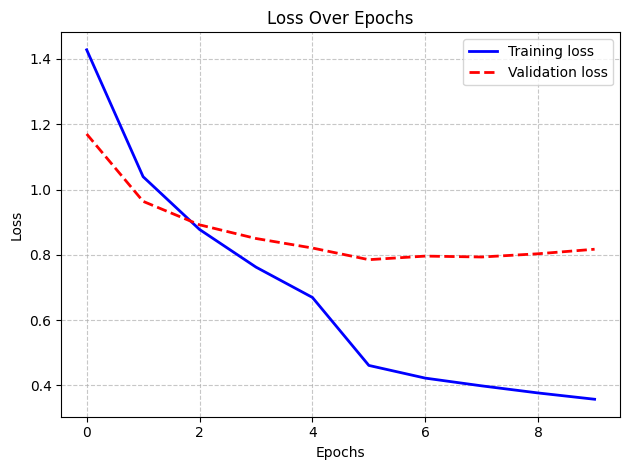

In [ ]:
model.visualize(history=history, metric="loss")

### Visualize the training and validation `accuracy`

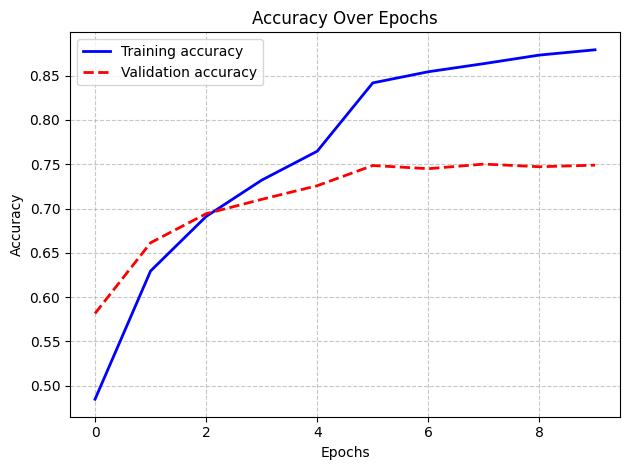

In [ ]:
model.visualize(history=history, metric="accuracy")

### Visualize the training and validation `recall`

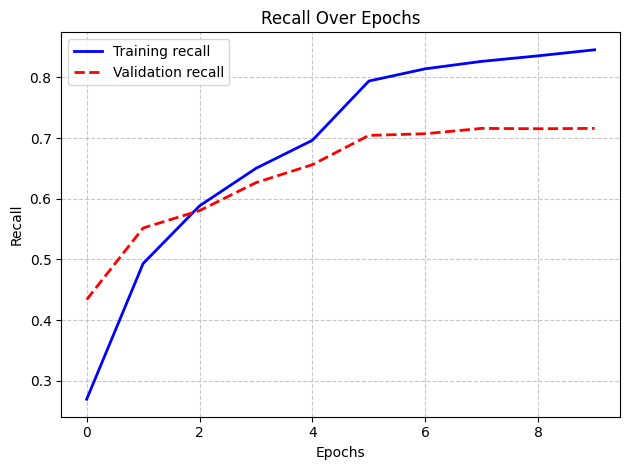

In [ ]:
model.visualize(history=history, metric="recall")

### Visualize the training and validation `precision`

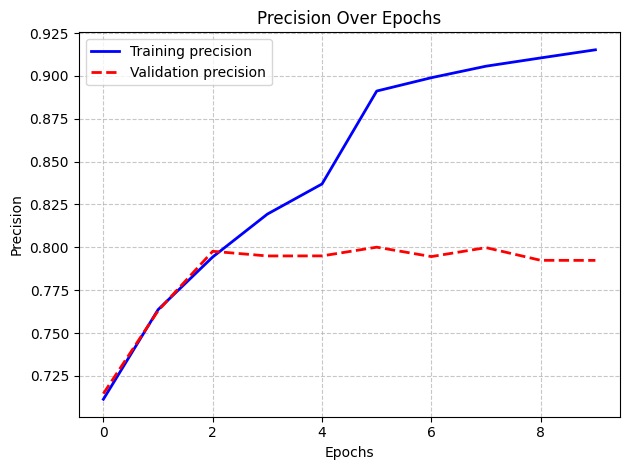

In [ ]:
model.visualize(history=history, metric="precision")

### Evaluate the model on the test set and display some predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7362 - loss: 0.7896 - precision: 0.7901 - recall: 0.6900
----------------
Loss     : 0.80
Accuracy : 0.73
Recall   : 0.69
Precision: 0.79
----------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


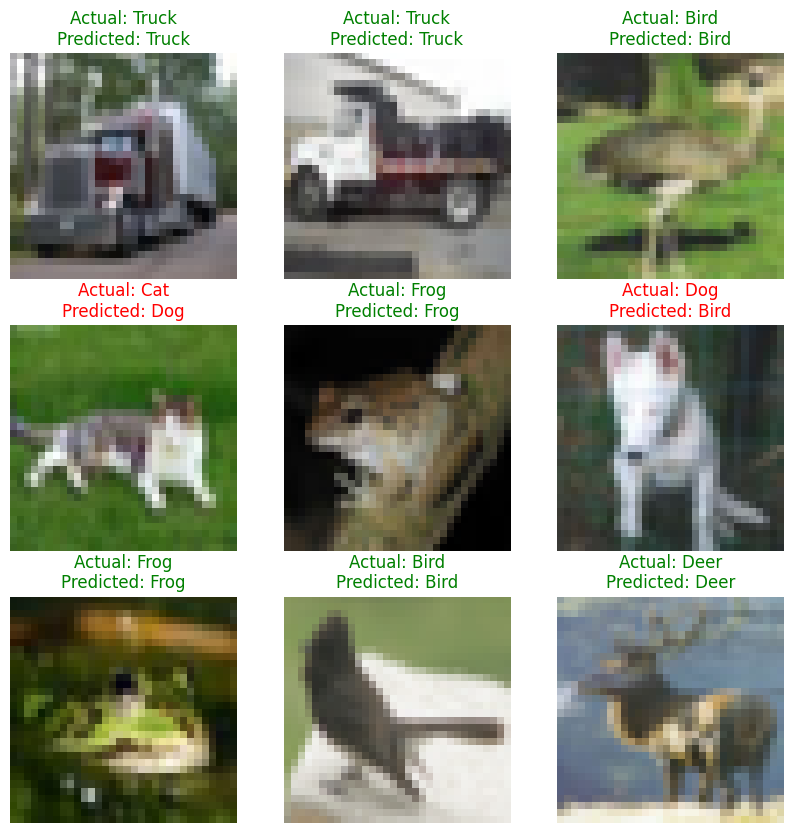

In [ ]:
model.evaluate(display=True)

### Display the `confusion matrix` and identify common misclassifications

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


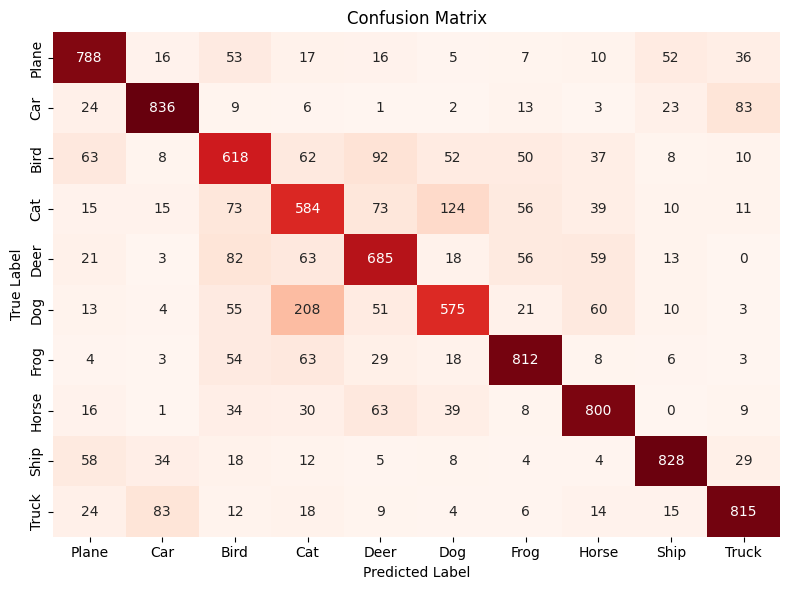

In [ ]:
model.visualize_confusion_matrix(classes=dataset.classes)

### Visualize the misclassified images

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


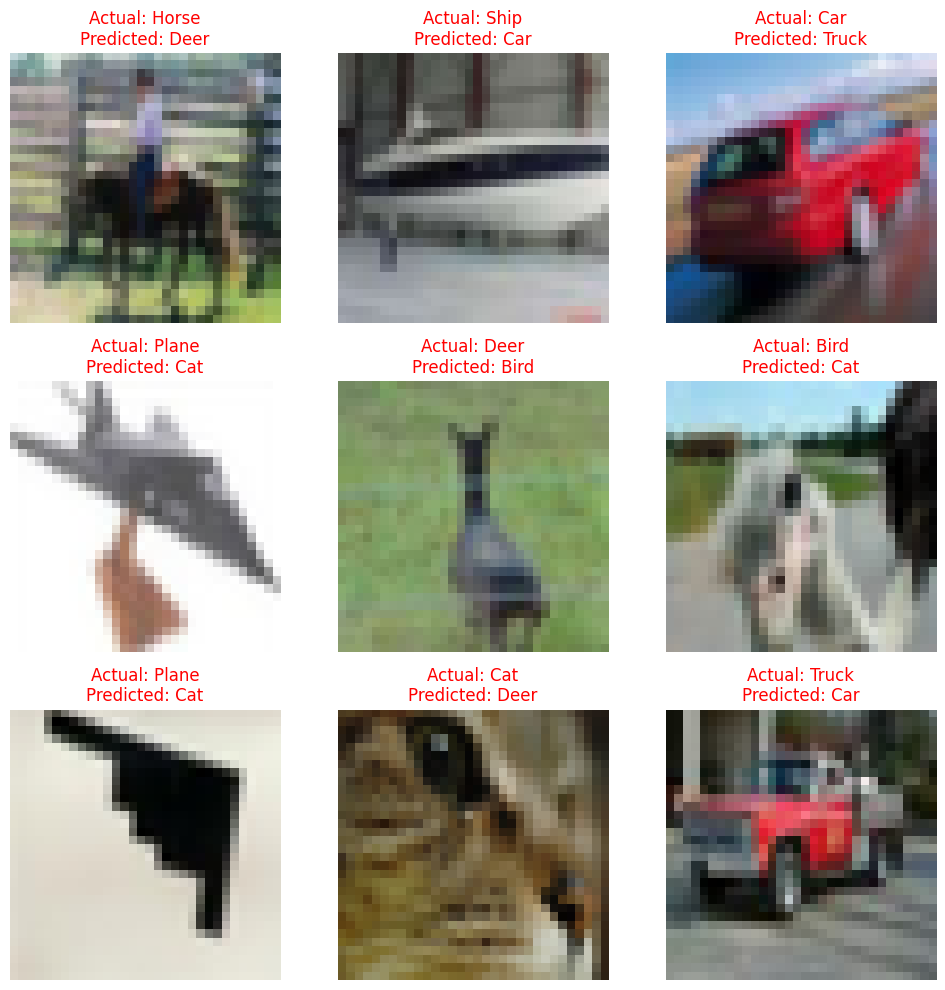

In [ ]:
model.visualize_misclassified(classes=dataset.classes)

### Comparing performance across different folds

Training fold 1/5...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 60ms/step - accuracy: 0.3747 - loss: 1.6988 - precision: 0.6078 - recall: 0.1470 - val_accuracy: 0.5779 - val_loss: 1.1911 - val_precision: 0.7282 - val_recall: 0.3979 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 66ms/step - accuracy: 0.6197 - loss: 1.0858 - precision: 0.7619 - recall: 0.4697 - val_accuracy: 0.6516 - val_loss: 1.0038 - val_precision: 0.7788 - val_recall: 0.5084 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 133s 59ms/step - accuracy: 0.6762 - loss: 0.9116 - precision: 0.7885 - recall: 0.5644 - val_accuracy: 0.6625 - val_loss: 0.9587 - val_precision: 0.7616 - val_recall: 0.5637 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/

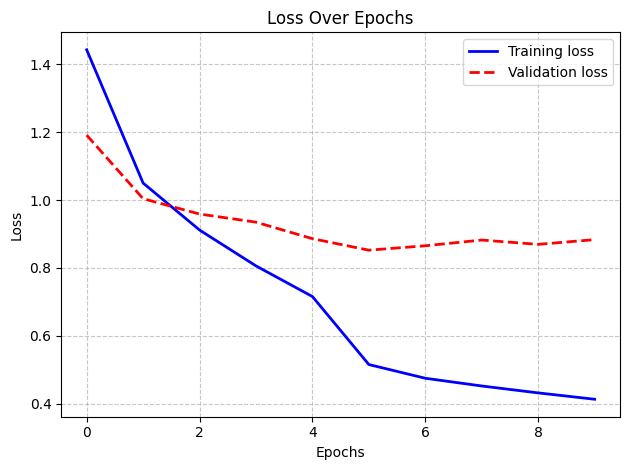

--------------------------------------------------
Loss    : 0.8521
Accuracy: 0.7172
--------------------------------------------------
Training fold 2/5...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.3458 - loss: 1.7719 - precision: 0.6145 - recall: 0.1169 - val_accuracy: 0.5651 - val_loss: 1.2179 - val_precision: 0.7435 - val_recall: 0.3711 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.5923 - loss: 1.1524 - precision: 0.7422 - recall: 0.4246 - val_accuracy: 0.6171 - val_loss: 1.0790 - val_precision: 0.7460 - val_recall: 0.4847 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - accuracy: 0.6663 - loss: 0.9542 - precision: 0.7861 - recall: 0.5427 - val_accuracy: 0.6389 - val_loss: 1.0145 - val_

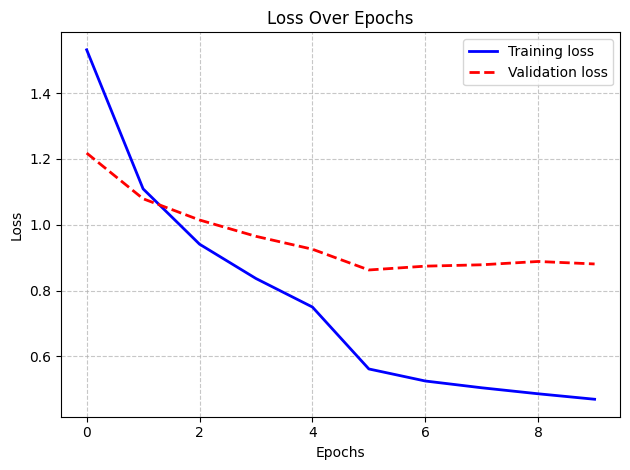

--------------------------------------------------
Loss    : 0.8573
Accuracy: 0.7127
--------------------------------------------------
Training fold 3/5...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.3702 - loss: 1.7131 - precision: 0.6273 - recall: 0.1407 - val_accuracy: 0.5617 - val_loss: 1.2226 - val_precision: 0.7346 - val_recall: 0.3906 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 63ms/step - accuracy: 0.6105 - loss: 1.1087 - precision: 0.7579 - recall: 0.4523 - val_accuracy: 0.6411 - val_loss: 1.0304 - val_precision: 0.7865 - val_recall: 0.4856 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.6741 - loss: 0.9268 - precision: 0.7865 - recall: 0.5581 - val_accuracy: 0.6661 - val_loss: 0.9588 - val_

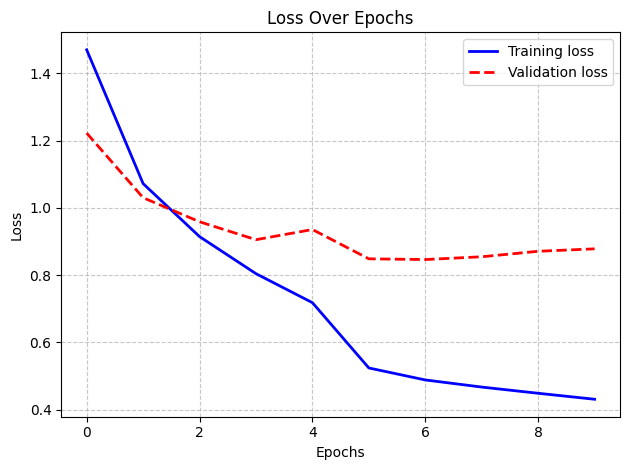

--------------------------------------------------
Loss    : 0.8537
Accuracy: 0.7161
--------------------------------------------------
Training fold 4/5...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 63ms/step - accuracy: 0.3789 - loss: 1.6952 - precision: 0.6097 - recall: 0.1482 - val_accuracy: 0.5745 - val_loss: 1.1746 - val_precision: 0.7276 - val_recall: 0.4241 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.6234 - loss: 1.0760 - precision: 0.7601 - recall: 0.4739 - val_accuracy: 0.6339 - val_loss: 1.0498 - val_precision: 0.7591 - val_recall: 0.5008 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.6872 - loss: 0.8901 - precision: 0.8032 - recall: 0.5777 - val_accuracy: 0.6848 - val_loss: 0.9070 - val_

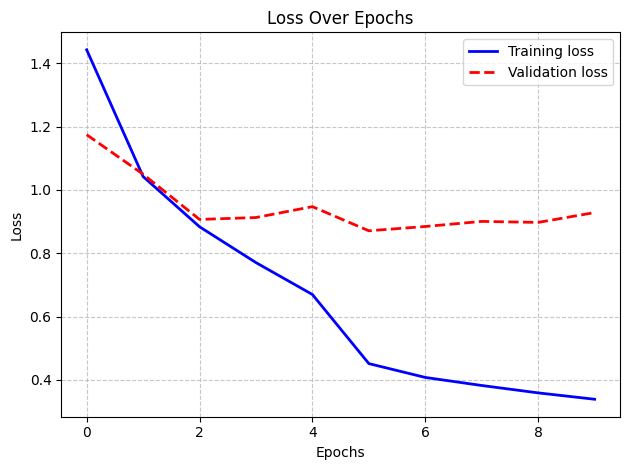

--------------------------------------------------
Loss    : 0.8581
Accuracy: 0.7161
--------------------------------------------------
Training fold 5/5...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 65ms/step - accuracy: 0.3751 - loss: 1.7076 - precision: 0.6070 - recall: 0.1440 - val_accuracy: 0.5667 - val_loss: 1.2248 - val_precision: 0.7240 - val_recall: 0.3958 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.6136 - loss: 1.0889 - precision: 0.7562 - recall: 0.4655 - val_accuracy: 0.6460 - val_loss: 1.0011 - val_precision: 0.7543 - val_recall: 0.5442 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.6781 - loss: 0.9098 - precision: 0.7892 - recall: 0.5698 - val_accuracy: 0.6728 - val_loss: 0.9426 - val_

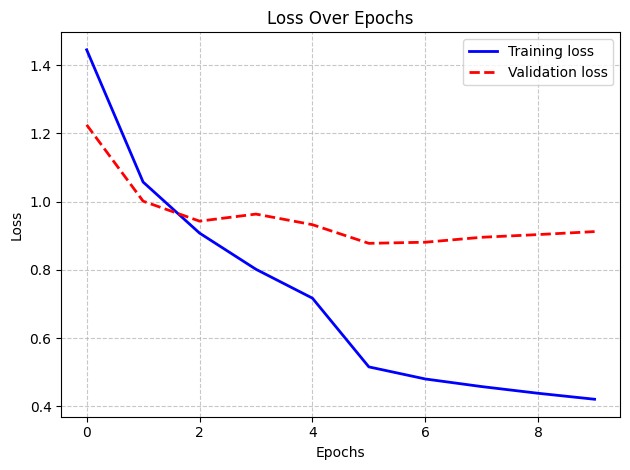

--------------------------------------------------
Loss    : 0.8619
Accuracy: 0.7141
--------------------------------------------------


In [ ]:
validation_loss, validation_accuracy = model.cross_validate(k=5, display=True)

## Experimenting with changes in model architecture and use data augmentation

### **Experiment-2**
- `dropout layers`: 2
- `dropout probabilites`: 0.1, 0.2
- `batch normalization`: 2
- `generate` for data augmentation

In [ ]:
splits                     = train_test_split(train_input, train_labels, test_size=0.1)
train_input                = splits[0]
validation_input           = splits[1]
train_labels               = splits[2]
validation_labels          = splits[3]
config.validation_split    = None
config.validation_data     = (validation_input, validation_labels)
config.train_input         = train_input
config.train_labels        = train_labels
config.dropout_layers      = 2
config.dropout_rates       = [0.1, 0.2]
config.batch_normalization = 2
config.generator           = dataset.generate(train_input)
model                      = Model(config=config)

model.build()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (32, 32, 32, 32)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (32, 32, 32, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 16, 16, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (32, 16, 16, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 8, 8, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (32, 8, 8, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (32, 4096)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (32, 128)                   │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (32, 128)                   │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (32, 64)                    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 553,866 (2.11 MB)

 Trainable params: 553,290 (2.11 MB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
model.compile()

history = model.train()


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 99s 102ms/step - accuracy: 0.3401 - loss: 1.9046 - precision: 0.4809 - recall: 0.1561 - val_accuracy: 0.5032 - val_loss: 1.3660 - val_precision: 0.6526 - val_recall: 0.3539 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 94s 102ms/step - accuracy: 0.4975 - loss: 1.3931 - precision: 0.6661 - recall: 0.3093 - val_accuracy: 0.5852 - val_loss: 1.2014 - val_precision: 0.7235 - val_recall: 0.4672 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 124s 134ms/step - accuracy: 0.5612 - loss: 1.2306 - precision: 0.7141 - recall: 0.3919 - val_accuracy: 0.6181 - val_loss: 1.0452 - val_precision: 0.7459 - val_recall: 0.5047 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
923/923 ━━━━━━━━━━━━━

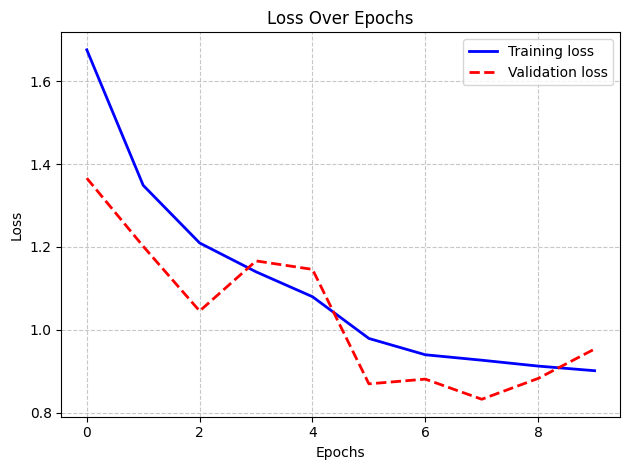

In [ ]:
model.visualize(history=history, metric="loss")

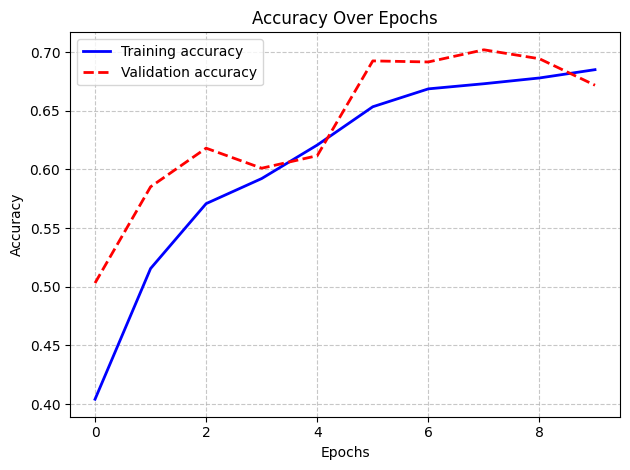

In [ ]:
model.visualize(history=history, metric="accuracy")

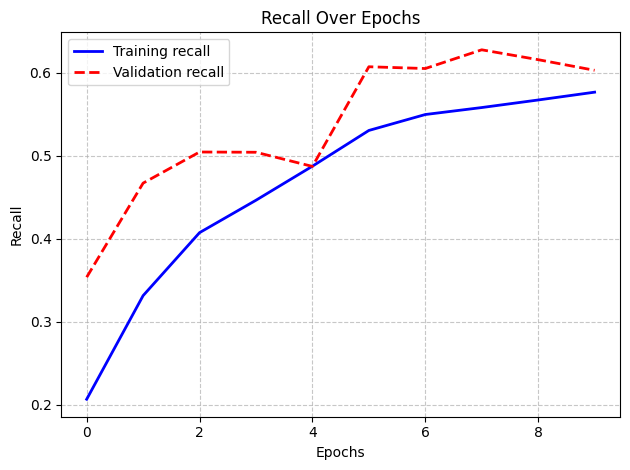

In [ ]:
model.visualize(history=history, metric="recall")

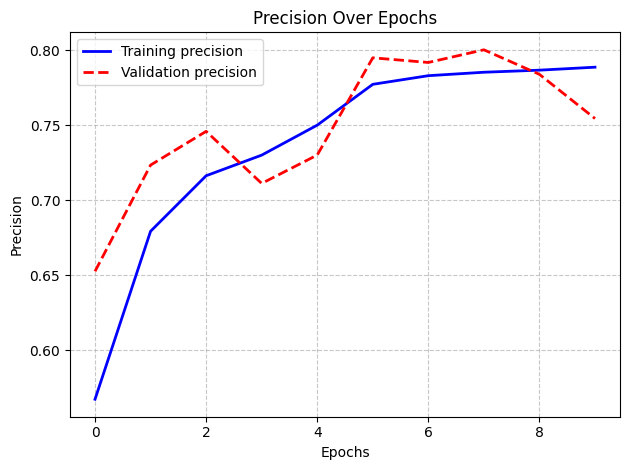

In [ ]:
model.visualize(history=history, metric="precision")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7130 - loss: 0.8247 - precision: 0.7915 - recall: 0.6299
----------------
Loss     : 0.84
Accuracy : 0.71
Recall   : 0.63
Precision: 0.79
----------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


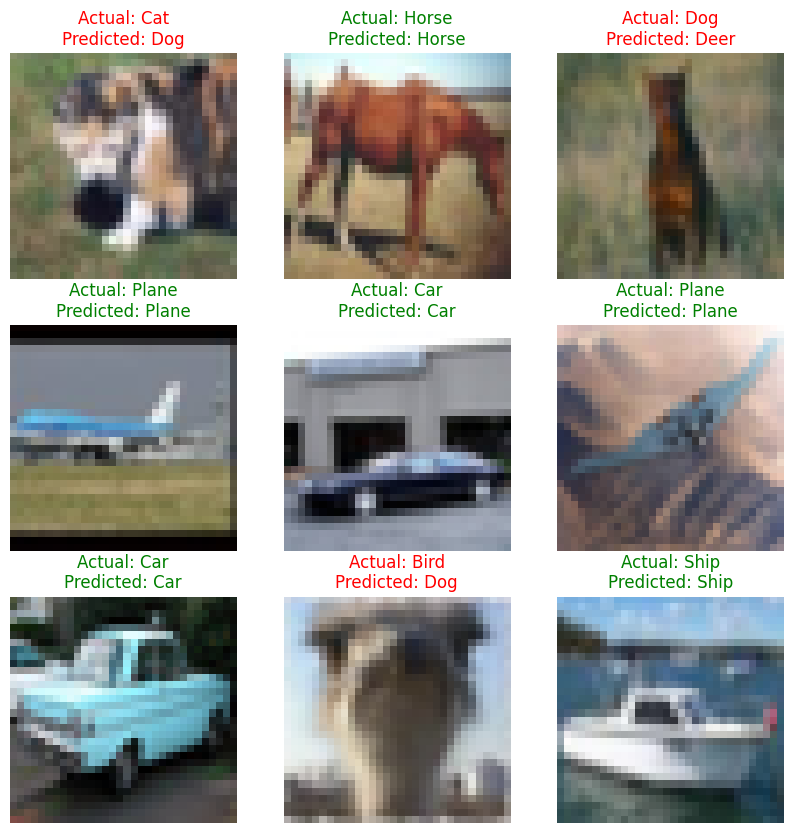

In [ ]:
model.evaluate(display=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


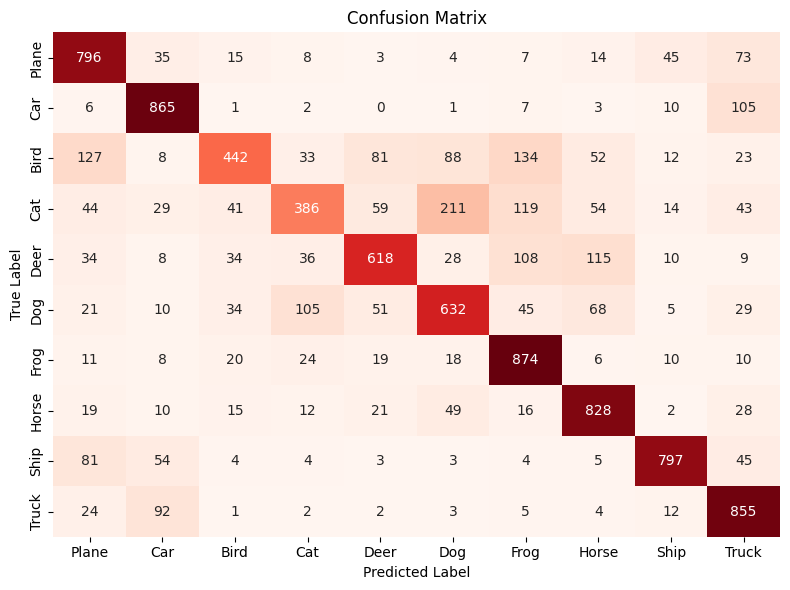

In [ ]:
model.visualize_confusion_matrix(classes=dataset.classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


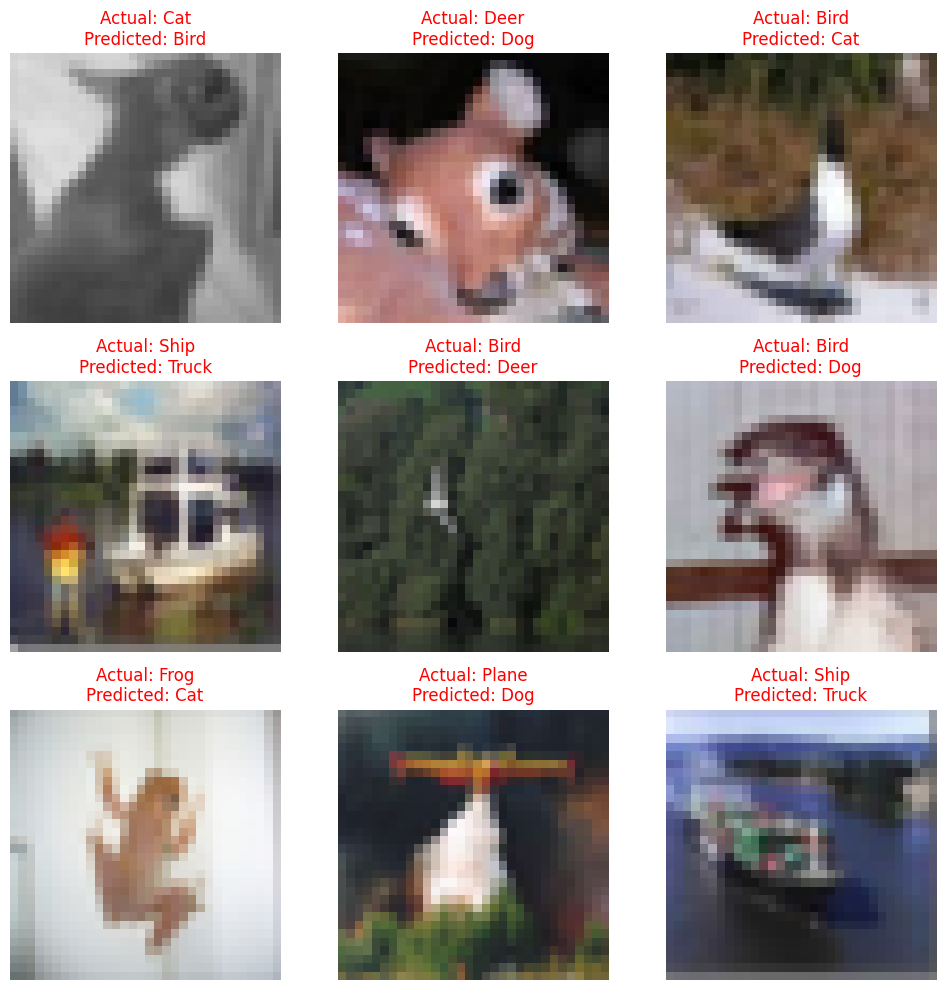

In [ ]:
model.visualize_misclassified(classes=dataset.classes)

### **Experiment-3**
- `dropout layers`: 0
- `convolutional layers`: 3
- `convolutional filters`: 64, 128, 256
- `convolutional kernlas`: (3, 3), (4, 4), (5, 5)
- `convolutional activations`: ELU
- `pooling layers`: 3
- `pooling kernels`: (2, 2), (3, 3), (4, 4)
- `batch normalization`: 3
- `hidden layers`: 3
- `hidden neurons`: 256, 128, 64
- `hidden activations`: GELU

In [ ]:
config.dropout_layers            = 0
config.dropout_rates             = [0]
config.convolutional_layers      = 3
config.convolutional_filters     = [64, 128, 256]
config.convolutional_kernels     = [(3, 3), (4, 4), (5, 5)]
config.convolutional_activations = ["elu", "elu", "elu"]
config.pooling_layers            = 3
config.pooling_kernels           = [(2, 2), (3, 3), (4, 4)]
config.batch_normalization       = 3
config.hidden_layers             = 3
config.hidden_neurons            = [256, 128, 64]
config.hidden_activations        = ["gelu", "gelu", "gelu"]
model                            = Model(config=config)

model.build()
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (32, 32, 32, 64)            │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (32, 32, 32, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (32, 16, 16, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (32, 16, 16, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (32, 16, 16, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (32, 5, 5, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (32, 5, 5, 256)             │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (32, 5, 5, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (32, 1, 1, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (32, 256)                   │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (32, 256)                   │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (32, 128)                   │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (32, 128)                   │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (32, 64)                    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,063,626 (4.06 MB)

 Trainable params: 1,061,834 (4.05 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
model.compile()

history = model.train()


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 374s 399ms/step - accuracy: 0.3540 - loss: 1.8203 - precision: 0.5183 - recall: 0.1465 - val_accuracy: 0.4895 - val_loss: 1.4382 - val_precision: 0.6457 - val_recall: 0.3411 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 358s 388ms/step - accuracy: 0.5538 - loss: 1.2514 - precision: 0.7015 - recall: 0.3924 - val_accuracy: 0.5181 - val_loss: 1.4877 - val_precision: 0.6018 - val_recall: 0.4307 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
923/923 ━━━━━━━━━━━━━━━━━━━━ 358s 388ms/step - accuracy: 0.6200 - loss: 1.0820 - precision: 0.7474 - recall: 0.4889 - val_accuracy: 0.5843 - val_loss: 1.2682 - val_precision: 0.6789 - val_recall: 0.5066 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
923/923 ━━━━━━━━━━━

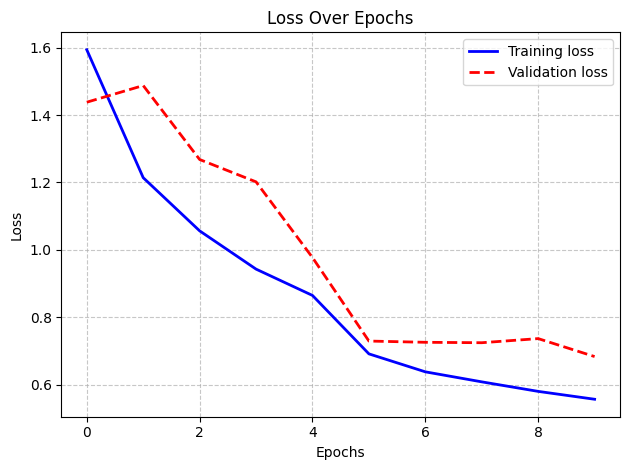

In [ ]:
model.visualize(history=history, metric="loss")

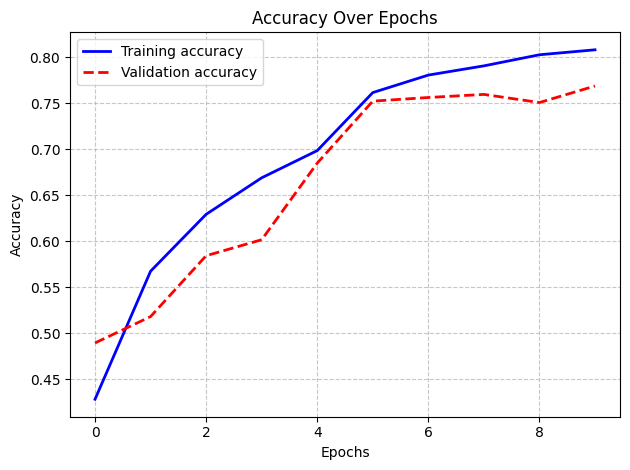

In [ ]:
model.visualize(history=history, metric="accuracy")

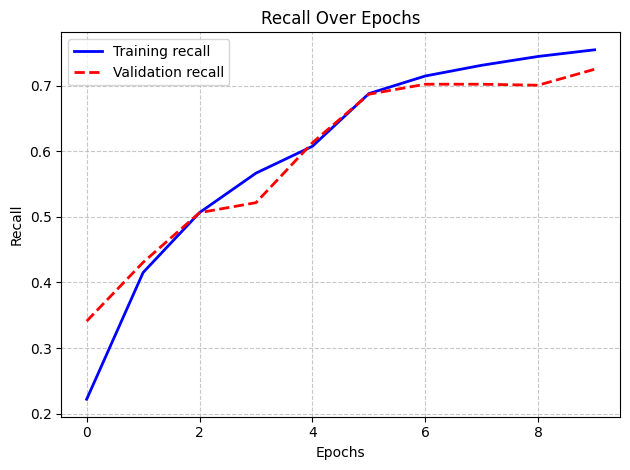

In [ ]:
model.visualize(history=history, metric="recall")

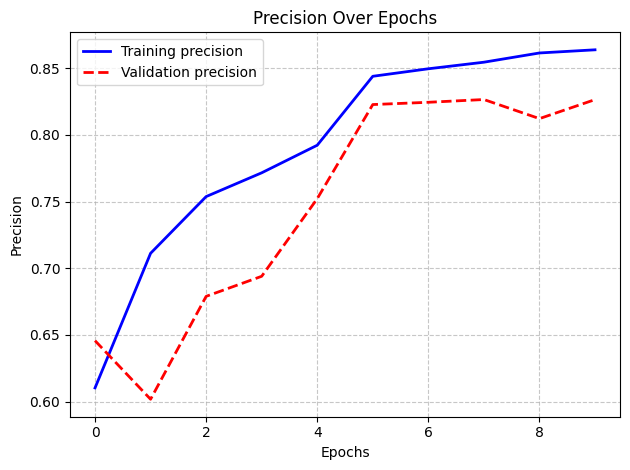

In [ ]:
model.visualize(history=history, metric="precision")

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.7730 - loss: 0.6755 - precision: 0.8276 - recall: 0.7242
----------------
Loss     : 0.68
Accuracy : 0.77
Recall   : 0.72
Precision: 0.83
----------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step


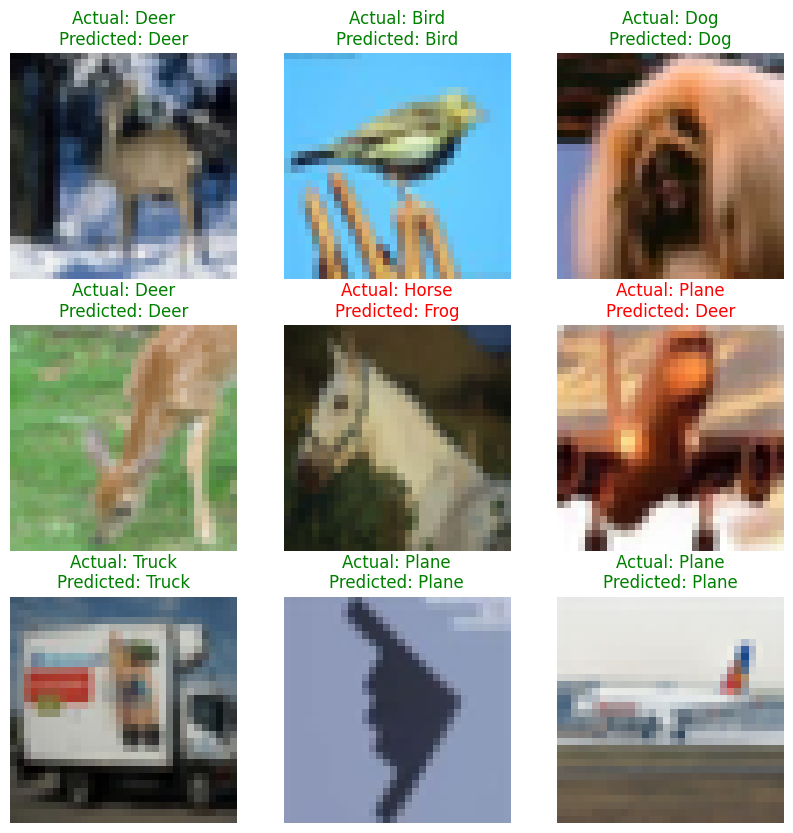

In [ ]:
model.evaluate(display=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step


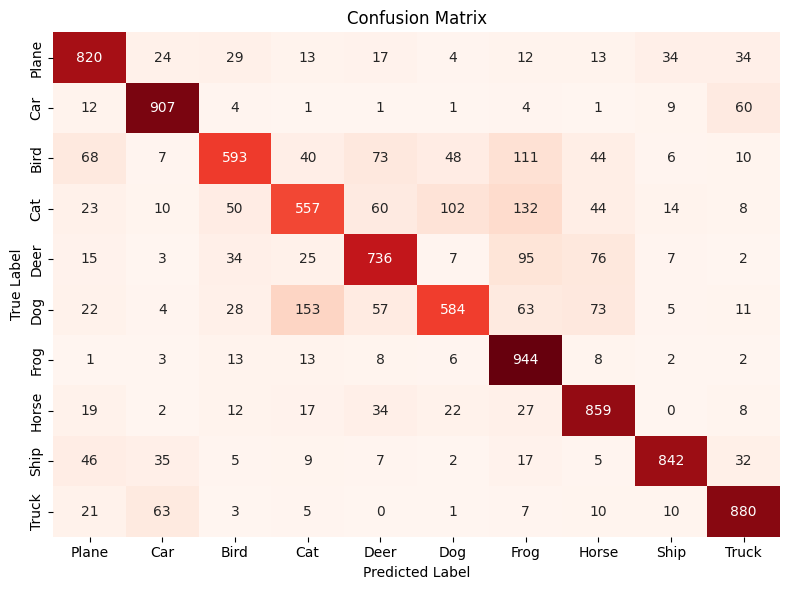

In [ ]:
model.visualize_confusion_matrix(classes=dataset.classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step


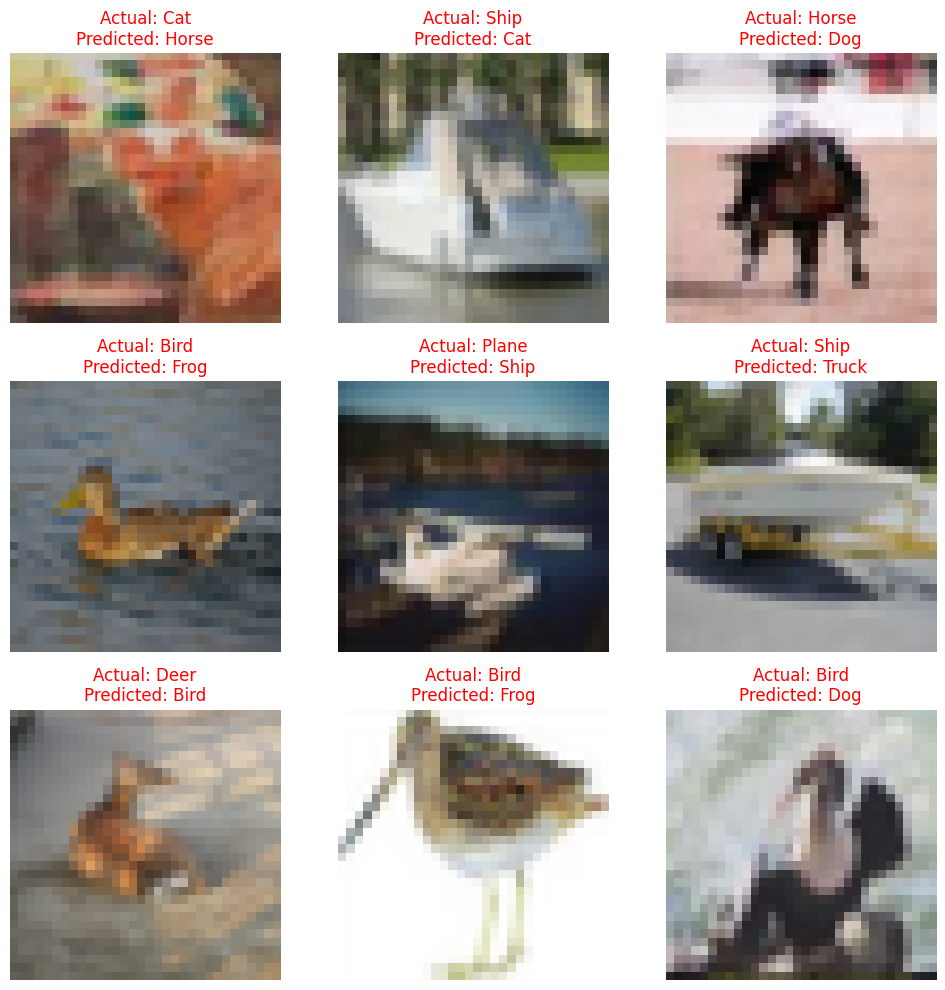

In [ ]:
model.visualize_misclassified(classes=dataset.classes)

### **Experiment-4**
- `dropout layers`: 3
- `dropout rates`: 0, 0, 0.2 (0 means no dropout)
- `convolutional layers`: 3
- `convolutional filters`: 64, 128, 256
- `convolutional kernlas`: (3, 3), (4, 4), (5, 5)
- `convolutional activations`: ELU
- `pooling layers`: 3
- `pooling kernels`: (2, 2), (3, 3), (4, 4)
- `batch normalization`: 3
- `hidden layers`: 3
- `hidden neurons`: 256, 128, 64
- `hidden activations`: ELU

- `without data augmentation`

In [ ]:
data                             = dataset.load(display=False)
config.train_input               = data[0]
config.train_labels              = data[2]
config.validation_split          = 0.1
config.validation_data           = None
config.convolutional_layers      = 3
config.convolutional_filters     = [64, 128, 256]
config.convolutional_kernels     = [(3, 3), (4, 4), (5, 5)]
config.convolutional_activations = ["elu", "elu", "elu"]
config.pooling_layers            = 3
config.pooling_kernels           = [(2, 2), (3, 3), (4, 4)]
config.batch_normalization       = 3
config.hidden_layers             = 3
config.hidden_neurons            = [256, 128, 64]
config.hidden_activations        = ["elu", "elu", "elu"]
config.dropout_layers            = 3
config.dropout_rates             = [0, 0, 0.2]
config.generator                 = None
model                            = Model(config=config)

model.build()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (32, 32, 32, 64)            │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (32, 32, 32, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 16, 16, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (32, 16, 16, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 16, 16, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (32, 16, 16, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 5, 5, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (32, 5, 5, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 5, 5, 256)             │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (32, 5, 5, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 1, 1, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (32, 1, 1, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 256)                   │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (32, 256)                   │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (32, 128)                   │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (32, 128)                   │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (32, 64)                    │             2

 Total params: 1,063,626 (4.06 MB)

 Trainable params: 1,061,834 (4.05 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
model.compile()

history = model.train()


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 560s 392ms/step - accuracy: 0.4062 - loss: 1.6880 - precision: 0.5478 - recall: 0.2413 - val_accuracy: 0.5526 - val_loss: 1.2565 - val_precision: 0.6825 - val_recall: 0.4282 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 559s 390ms/step - accuracy: 0.6489 - loss: 1.0125 - precision: 0.7664 - recall: 0.5336 - val_accuracy: 0.5694 - val_loss: 1.2424 - val_precision: 0.6412 - val_recall: 0.4600 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 561s 399ms/step - accuracy: 0.7173 - loss: 0.8246 - precision: 0.8084 - recall: 0.6304 - val_accuracy: 0.6044 - val_loss: 1.2828 - val_precision: 0.7142 - val_recall: 0.5238 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
1407/1407 ━━━

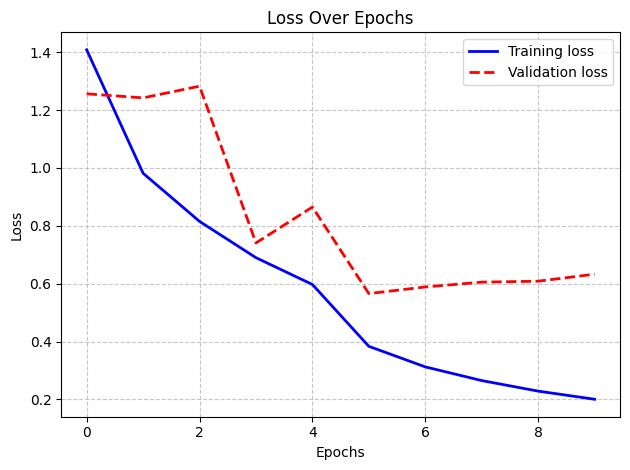

In [ ]:
model.visualize(history=history, metric="loss")

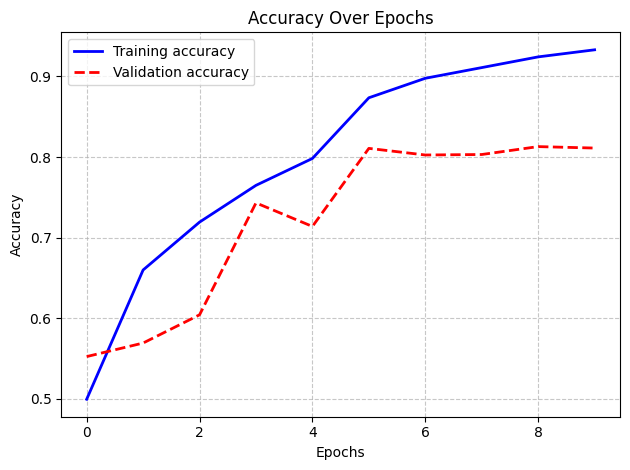

In [ ]:
model.visualize(history=history, metric="accuracy")

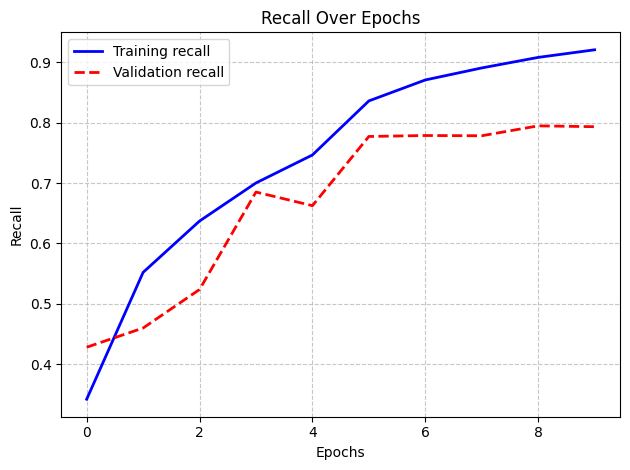

In [ ]:
model.visualize(history=history, metric="recall")

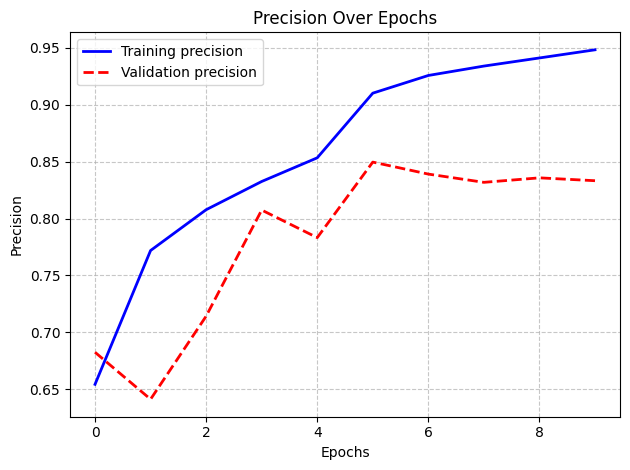

In [ ]:
model.visualize(history=history, metric="precision")

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.8017 - loss: 0.5894 - precision: 0.8498 - recall: 0.7643
----------------
Loss     : 0.59
Accuracy : 0.80
Recall   : 0.77
Precision: 0.85
----------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step


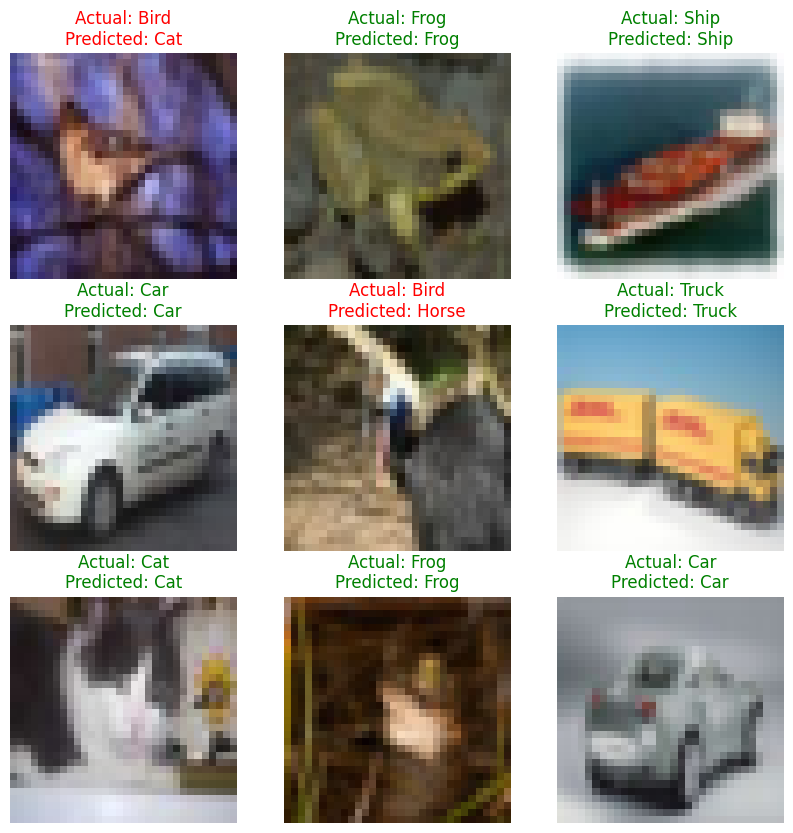

In [ ]:
model.evaluate(display=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step


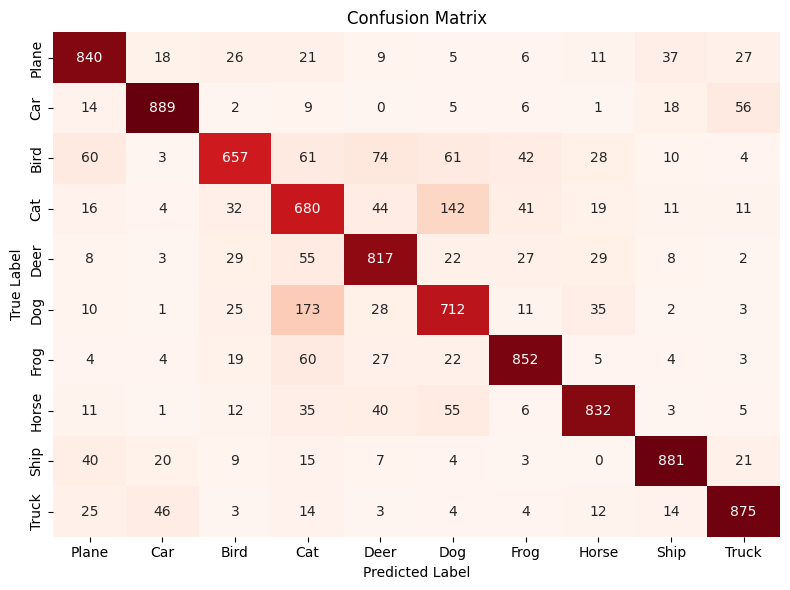

In [ ]:
model.visualize_confusion_matrix(classes=dataset.classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step


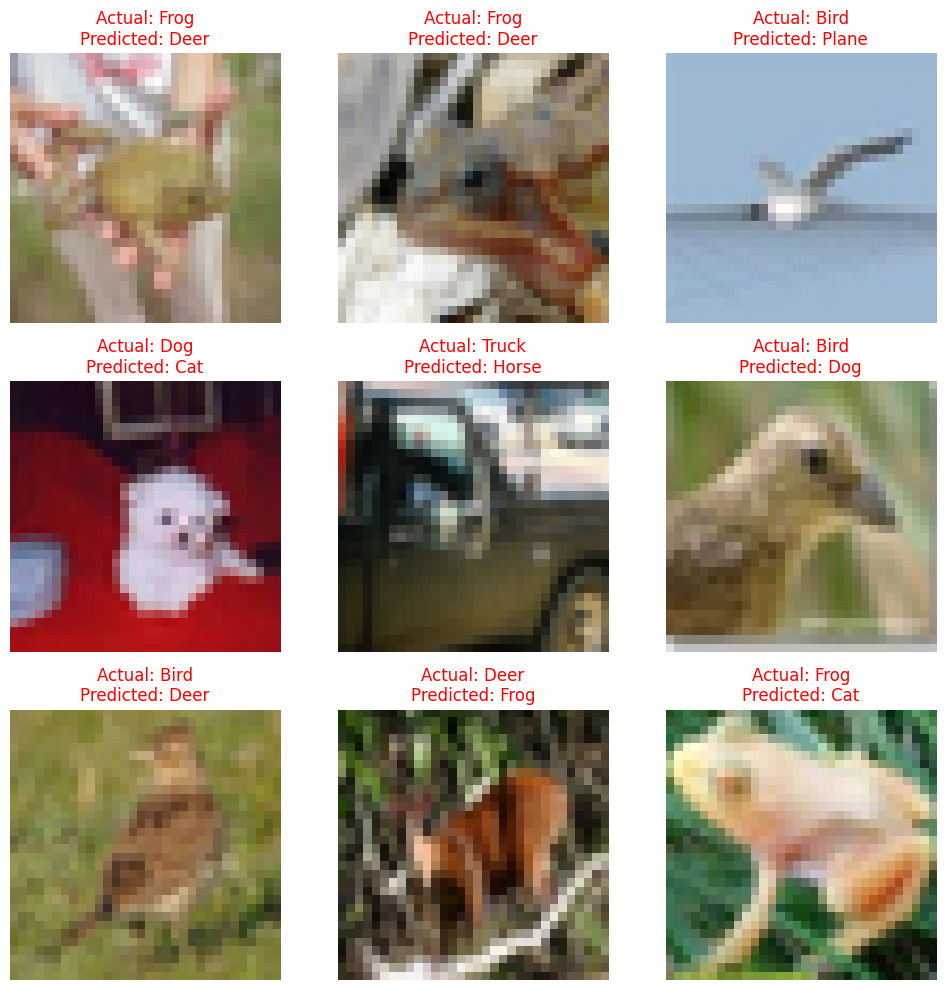

In [ ]:
model.visualize_misclassified(classes=dataset.classes)